In [1]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import os
import sys
os.chdir('../')
sys.path.append('./')
os.getcwd()
from model import DeepJSCC
import matplotlib.pyplot as plt
import matplotlib
from utils import get_psnr, image_normalization

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Eval para

In [10]:
channel = 'AWGN'
saved = r'out_original\checkpoints\CIFAR10_8_19.0_0.17_AWGN_09h03m16s_on_Mar_27_2025\epoch_999.pkl'

snr = 2000
test_image_dir = r'demo\kodim08.png'
times = 10

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

### Trans from nn.DataParallel to nn.Module

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
state_dict = torch.load(saved, map_location=torch.device('cpu'))
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# model.load_state_dict(torch.load(saved))

### Load model from checkpoint

In [14]:
file_name = os.path.basename(os.path.dirname(saved))
c = file_name.split('_')[1]
c = int(c)
model = DeepJSCC(c=c, channel_type=channel, snr=snr)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(new_state_dict)
model.change_channel(channel, snr)

### Eval for times

In [15]:
test_image.shape

torch.Size([3, 512, 768])

average psnr is 19.87310333251953 for 10 times on kodim08.png


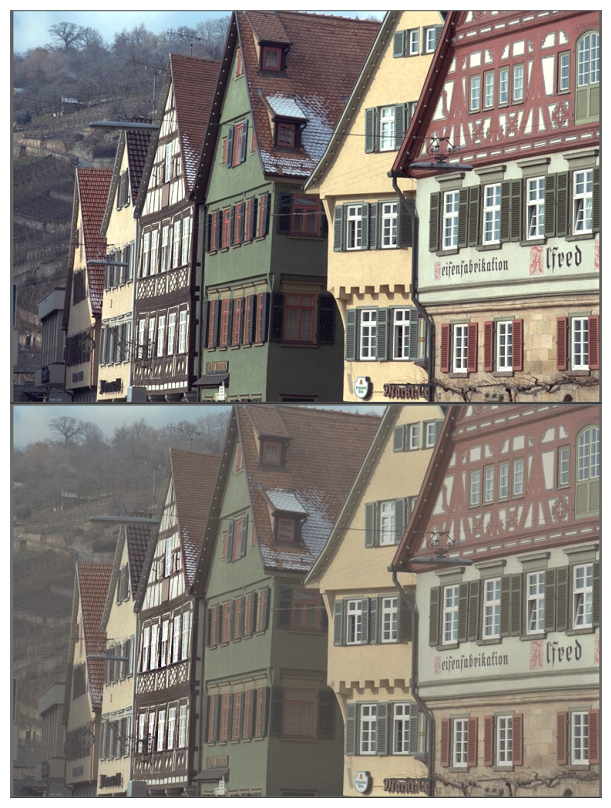

In [16]:
psnr_all = 0.0
with torch.no_grad():

    for i in range(times):
        demo_image = model(test_image)
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)
    demo_image = demo_image.numpy()

dpi = 100
height, width = demo_image.shape[1], demo_image.shape[2]
figsize = (width / dpi, height / dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')

print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))